<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/densenet_0618.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split'

import os
os.chdir('/content/gdrive/My Drive/dataset_split')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=16,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=16,
                                                        class_mode='categorical')

Found 36179 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


In [4]:
SIZE=64
N_ch=3

In [5]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(33, activation = 'softmax', name='root')(x)

    # model
    model = Model(input,output)
    #layer.trainable = False
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [6]:
model = build_densenet()
#annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

my_callbacks = [
    EarlyStopping(patience=10),
    ModelCheckpoint('model.h5', save_best_only=True)
]
# Fits the model on batches with real-time data augmentation
dense = model.fit_generator(train_generator,
                            steps_per_epoch=566,
                            epochs=20,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

29089792/29084464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
____________________________________________________________

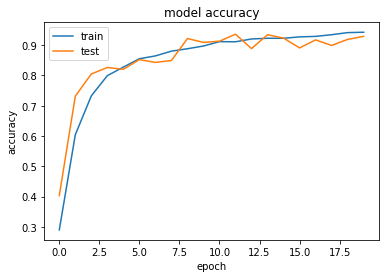

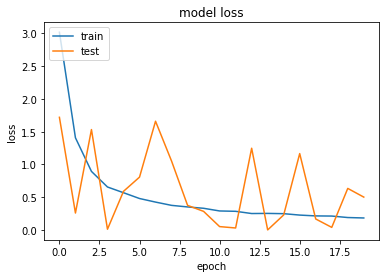

In [10]:
# accuracy plot 
plt.plot(dense.history['accuracy'])
plt.plot(dense.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(dense.history['loss'])
plt.plot(dense.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()